In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo
from scipy import stats
from datetime import datetime, timedelta
import warnings
from IPython.display import Image, display
warnings.filterwarnings('ignore')
pio.templates.default = "plotly_dark"
pio.renderers.default = "png"
pio.kaleido.scope.default_scale = 2
pio.kaleido.scope.default_width = 1400
pio.kaleido.scope.default_height = 900

In [2]:
def fetch_stock_data():
    tickers = {
        'BBOX.NS':'Black Box Limited ',
        'BEL.NS':'Bharat Electronics Limited',
        'VBL.NS': 'Varun Beverages Limited',
        'SHANTIGEAR.NS':'Shanthi Gears Limited',
        'HDFCBANK.NS': 'HDFC Bank Limited',
        'VSTIND.NS':'VST Industries Limited'
    }
    market_ticker = '^CRSLDX'
    print(f"Stocks: {list(tickers.keys())}")
    print(f"Market Proxy: {market_ticker}")
    print(f"Period: 6 years (for rolling calculations)")
    # Fetch data - Get closing prices for all stocks
    all_tickers = list(tickers.keys()) + [market_ticker]
    data = yf.download(all_tickers, period='6y', interval='1d')['Close']
    if len(all_tickers) == 1:
        data = data.to_frame(all_tickers[0])
    print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total trading days: {len(data)}")
    return data, tickers, market_ticker

In [3]:
price_data, stock_info, market_ticker = fetch_stock_data()
print(price_data.head())

Stocks: ['BBOX.NS', 'BEL.NS', 'VBL.NS', 'SHANTIGEAR.NS', 'HDFCBANK.NS', 'VSTIND.NS']
Market Proxy: ^CRSLDX
Period: 6 years (for rolling calculations)
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed


Date range: 2019-07-29 to 2025-07-29
Total trading days: 1485
Ticker        BBOX.NS     BEL.NS  HDFCBANK.NS  SHANTIGEAR.NS     VBL.NS  \
Date                                                                      
2019-07-29  17.049999  27.218222  1065.518066      90.055893  55.768764   
2019-07-30  17.000000  28.876261  1069.292480      88.490501  55.472149   
2019-07-31  17.219999  30.138138  1069.007690      94.291641  55.738228   
2019-08-01  16.290001  28.978971  1054.835938      90.055893  54.385994   
2019-08-02  15.760000  27.981213  1051.298950      87.615715  54.132996   

Ticker       VSTIND.NS      ^CRSLDX  
Date                                 
2019-07-29  240.722778  9108.888672  
2019-07-30  237.886795  9004.038086  
2019-07-31  239.165466  9044.938477  
2019-08-01  238.783295  8935.738281  
2019-08-02  237.883179  8943.938477  


In [4]:
def calculate_returns(price_data):
    returns = price_data.pct_change().dropna()
    print(f"Return data shape: {returns.shape}")
    return returns

returns_data = calculate_returns(price_data)
print(returns_data.describe().round(4))

Return data shape: (1484, 7)
Ticker    BBOX.NS     BEL.NS  HDFCBANK.NS  SHANTIGEAR.NS     VBL.NS  \
count   1484.0000  1484.0000    1484.0000      1484.0000  1484.0000   
mean       0.0028     0.0021       0.0006         0.0017     0.0018   
std        0.0340     0.0237       0.0166         0.0295     0.0236   
min       -0.0937    -0.1980      -0.1261        -0.1296    -0.0915   
25%       -0.0184    -0.0102      -0.0073        -0.0128    -0.0108   
50%       -0.0010     0.0010       0.0007        -0.0010     0.0003   
75%        0.0183     0.0141       0.0078         0.0124     0.0143   
max        0.2000     0.1129       0.1160         0.2000     0.1207   

Ticker  VSTIND.NS    ^CRSLDX  
count   1484.0000  1484.0000  
mean       0.0003     0.0007  
std        0.0189     0.0114  
min       -0.1678    -0.1281  
25%       -0.0077    -0.0040  
50%       -0.0001     0.0014  
75%        0.0076     0.0064  
max        0.2000     0.0769  


In [5]:
def calculate_rolling_beta(stock_returns, market_returns, window):
    betas = []
    for i in range(window, len(stock_returns)):
        stock_window = stock_returns.iloc[i-window:i]
        market_window = market_returns.iloc[i-window:i]
        if len(stock_window.dropna()) < window * 0.8:
            betas.append(np.nan)
            continue
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                market_window.dropna(), stock_window.dropna()
            )
            betas.append(slope)
        except:
            betas.append(np.nan)
    beta_series = pd.Series(betas, index=stock_returns.index[window:])
    return beta_series

In [6]:
def calculate_all_rolling_betas(returns_data, market_ticker):
    windows = {
        '1Y': 252,
        '2Y': 504,
        '5Y': 1260
    }
    market_returns = returns_data[market_ticker]
    rolling_betas = {}
    print("\nCalculating rolling betas...")
    for stock in returns_data.columns:
        if stock == market_ticker:
            continue
        print(f"Processing {stock}...")
        rolling_betas[stock] = {}
        for window_name, window_days in windows.items():
            if len(returns_data) >= window_days:
                beta_series = calculate_rolling_beta(
                    returns_data[stock], market_returns, window_days
                )
                rolling_betas[stock][window_name] = beta_series
            else:
                print(f"Insufficient data for {window_name} window")
    print("Rolling beta calculations completed")
    return rolling_betas, windows

rolling_betas, time_windows = calculate_all_rolling_betas(returns_data, market_ticker)


Calculating rolling betas...
Processing BBOX.NS...
Processing BEL.NS...
Processing HDFCBANK.NS...
Processing SHANTIGEAR.NS...
Processing VBL.NS...
Processing VSTIND.NS...
Rolling beta calculations completed


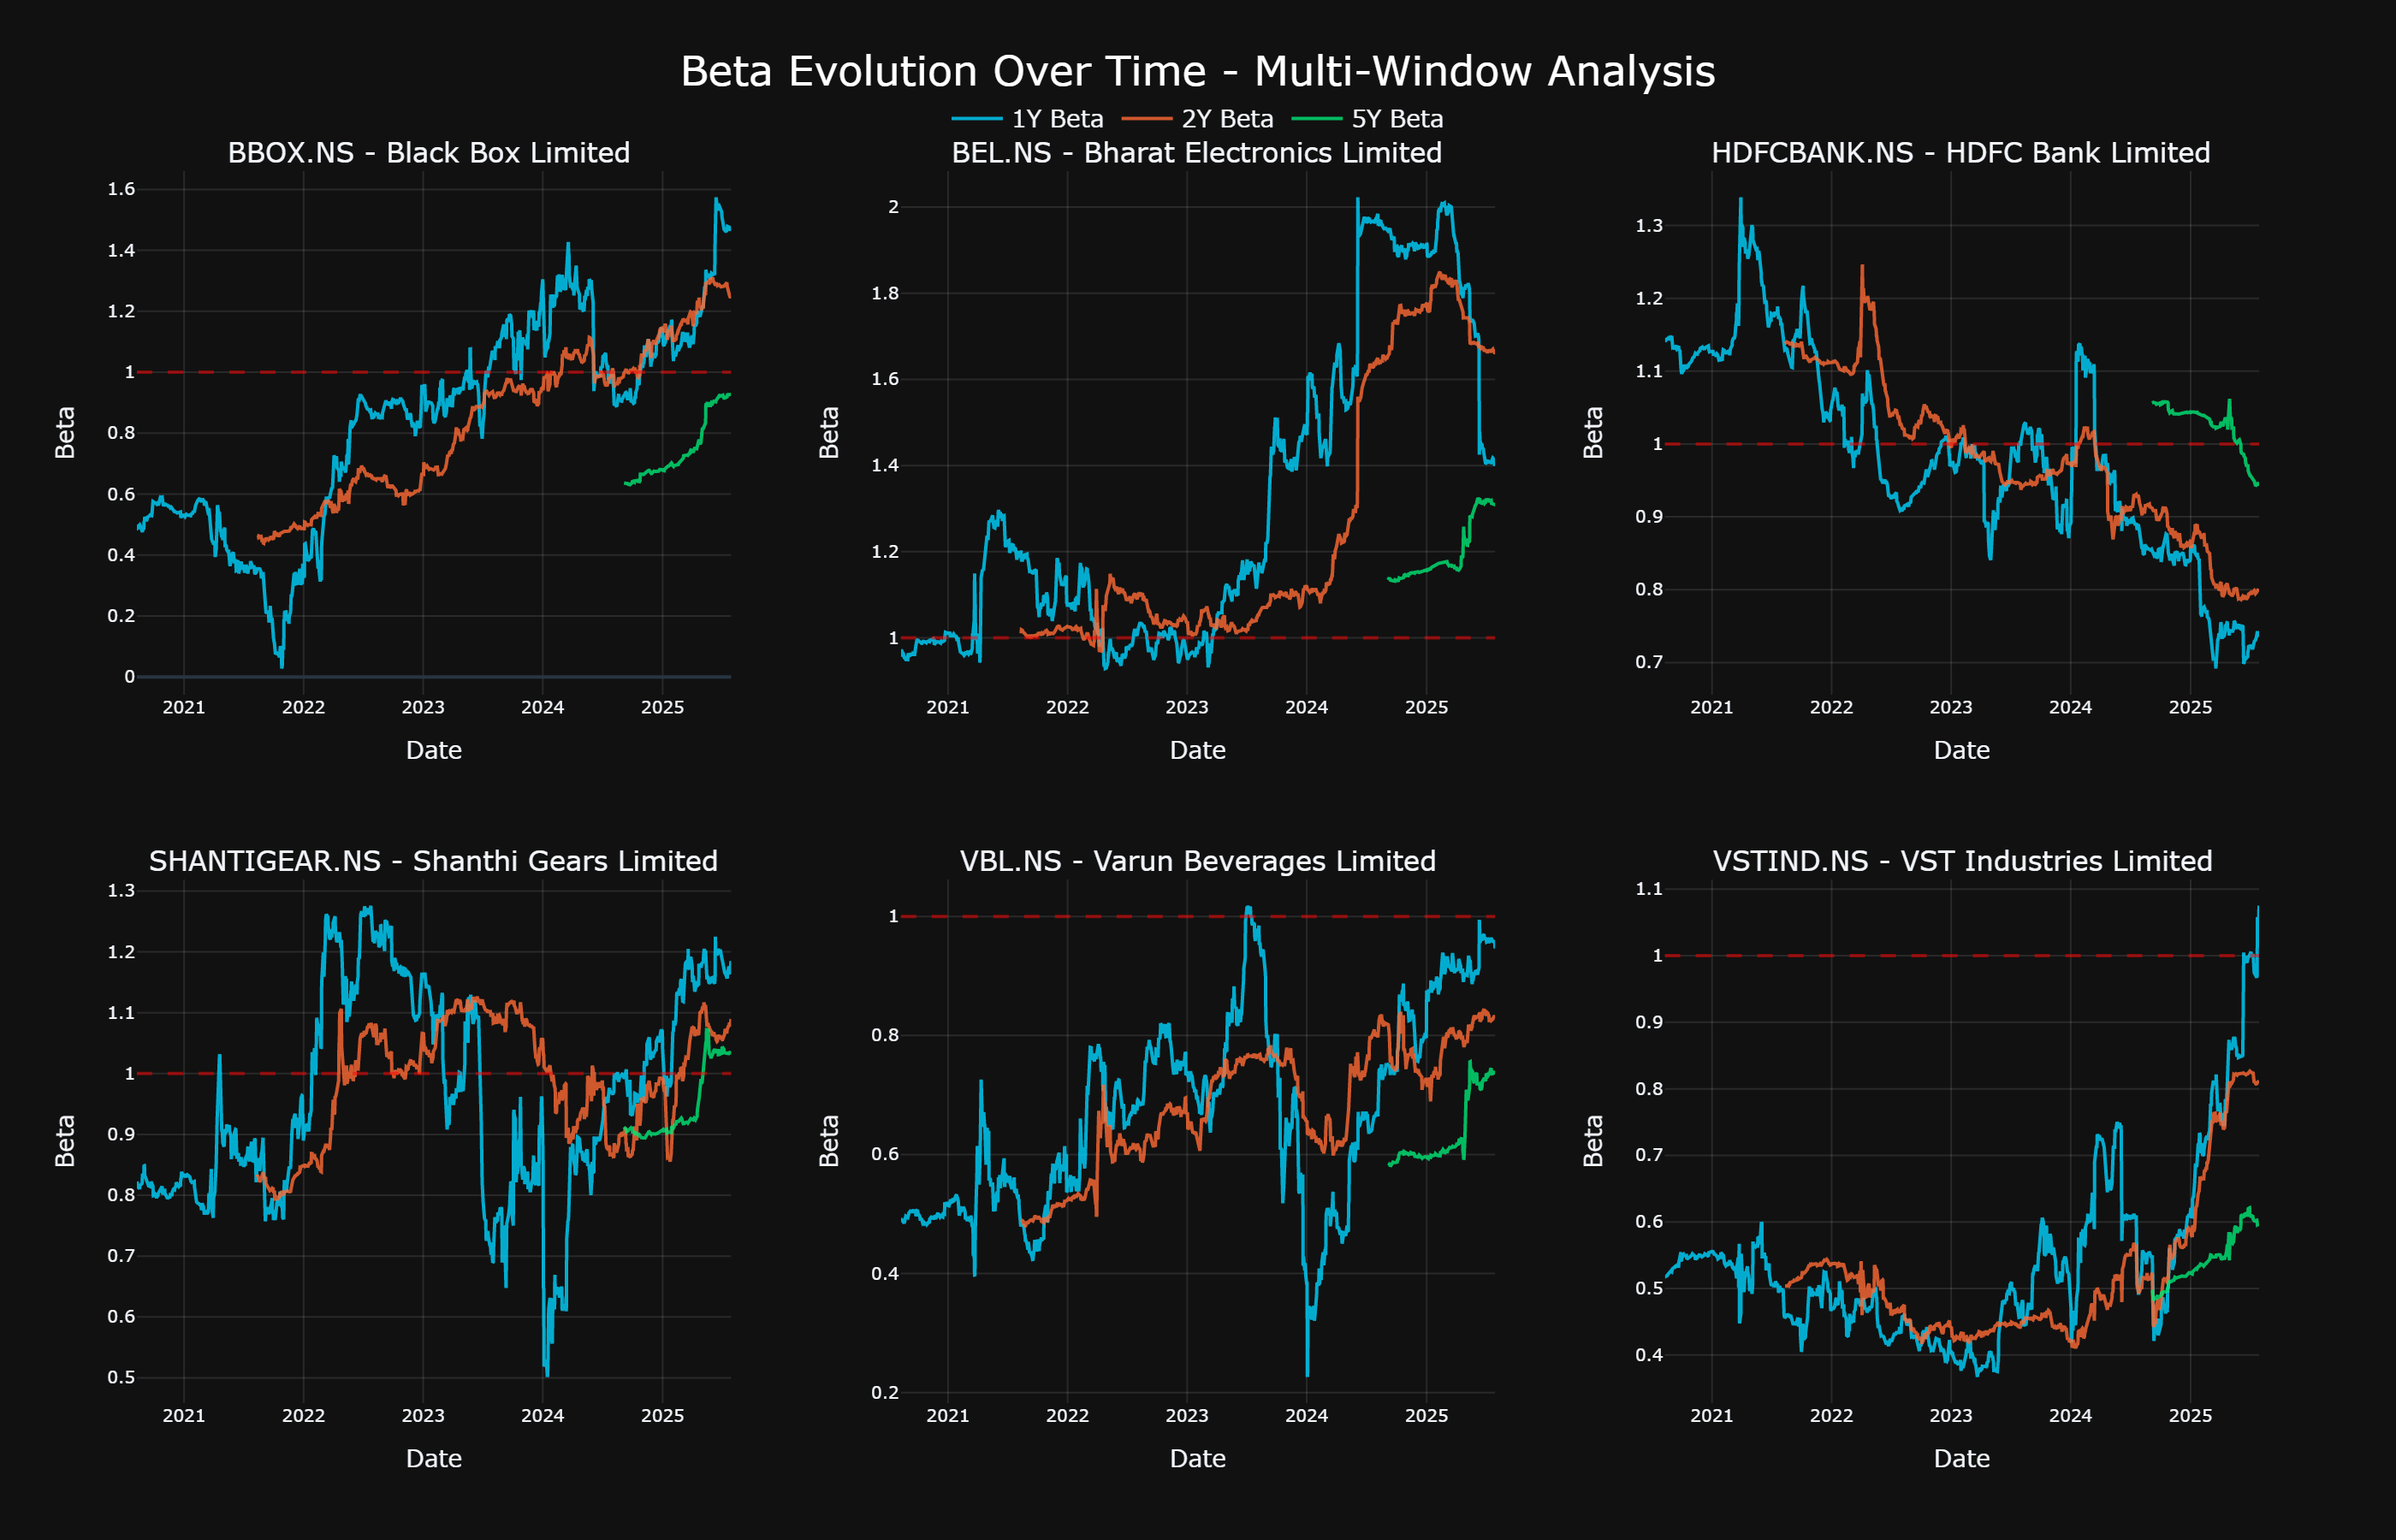

In [7]:
def plot_beta_evolution_plotly(rolling_betas, stock_info, save_plot=True):
    n_stocks = len(rolling_betas)
    rows = 2
    cols = 3
    fig = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=[f'{stock} - {stock_info.get(stock, stock)}' for stock in rolling_betas.keys()],
        vertical_spacing=0.15,
        horizontal_spacing=0.08
    )
    colors = ['#00D4FF', '#FF6B35', '#00E676']
    for idx, (stock, betas) in enumerate(rolling_betas.items()):
        row = (idx // cols) + 1
        col = (idx % cols) + 1
        for i, (window, beta_series) in enumerate(betas.items()):
            fig.add_trace(
                go.Scatter(
                    x=beta_series.index,
                    y=beta_series.values,
                    name=f'{window} Beta',
                    line=dict(color=colors[i], width=2),
                    showlegend=(idx == 0),
                    legendgroup=window,
                    opacity=0.8
                ),
                row=row,
                col=col
            )
        fig.add_hline(
            y=1,
            line_dash="dash",
            line_color="red",
            opacity=0.5,
            row=row,
            col=col
        )
    fig.update_layout(
        title=dict(
            text='Beta Evolution Over Time - Multi-Window Analysis',
            font=dict(size=24, color='white'),
            x=0.5
        ),
        height=900,
        width=1400,
        showlegend=True,
        template='plotly_dark',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5,
            font=dict(size=14)
        )
    )
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='rgba(255,255,255,0.1)',
        tickfont=dict(size=10)
    )
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='rgba(255,255,255,0.1)',
        title_text="Beta",
        tickfont=dict(size=10)
    )
    for i in range(1, rows + 1):
        for j in range(1, cols + 1):
            fig.update_xaxes(title_text="Date", row=i, col=j)
    if save_plot:
        fig.write_image("beta_evolution_timeline.png", width=2800, height=1800, scale=2)
        fig.write_image("beta_evolution_timeline.svg", width=2800, height=1800)
        fig.write_html("beta_evolution_timeline.html")
    fig.show()
    return fig

beta_evolution_fig = plot_beta_evolution_plotly(rolling_betas, stock_info)

In [8]:
def analyze_beta_stability(rolling_betas):
    stability_metrics = {}
    for stock, betas in rolling_betas.items():
        stability_metrics[stock] = {}
        for window, beta_series in betas.items():
            clean_betas = beta_series.dropna()
            if len(clean_betas) > 10:
                stability_metrics[stock][window] = {
                    'mean_beta': clean_betas.mean(),
                    'std_beta': clean_betas.std(),
                    'min_beta': clean_betas.min(),
                    'max_beta': clean_betas.max(),
                    'range_beta': clean_betas.max() - clean_betas.min(),
                    'cv_beta': clean_betas.std() / abs(clean_betas.mean()) if clean_betas.mean() != 0 else np.inf
                }
    return stability_metrics

stability_metrics = analyze_beta_stability(rolling_betas)
print("\n BETA STABILITY ANALYSIS")
print("=" * 60)
for stock in stability_metrics:
    print(f"\n{stock} ({stock_info.get(stock, stock)}):")
    print("-" * 40)
    for window in ['1Y', '2Y', '5Y']:
        if window in stability_metrics[stock]:
            metrics = stability_metrics[stock][window]
            print(f"{window} Beta: ￿={metrics['mean_beta']:.3f}, "
                  f"￿={metrics['std_beta']:.3f}, "
                  f"Range=[{metrics['min_beta']:.3f}, {metrics['max_beta']:.3f}], "
                  f"CV={metrics['cv_beta']:.3f}")



 BETA STABILITY ANALYSIS

BBOX.NS (Black Box Limited ):
----------------------------------------
1Y Beta: ￿=0.836, ￿=0.337, Range=[0.028, 1.574], CV=0.403
2Y Beta: ￿=0.847, ￿=0.248, Range=[0.439, 1.311], CV=0.292
5Y Beta: ￿=0.748, ￿=0.103, Range=[0.628, 0.929], CV=0.138

BEL.NS (Bharat Electronics Limited):
----------------------------------------
1Y Beta: ￿=1.307, ￿=0.355, Range=[0.929, 2.023], CV=0.272
2Y Beta: ￿=1.259, ￿=0.306, Range=[0.967, 1.850], CV=0.243
5Y Beta: ￿=1.199, ￿=0.068, Range=[1.131, 1.324], CV=0.057

HDFCBANK.NS (HDFC Bank Limited):
----------------------------------------
1Y Beta: ￿=0.987, ￿=0.136, Range=[0.692, 1.339], CV=0.138
2Y Beta: ￿=0.978, ￿=0.103, Range=[0.786, 1.247], CV=0.105
5Y Beta: ￿=1.025, ￿=0.033, Range=[0.942, 1.062], CV=0.032

SHANTIGEAR.NS (Shanthi Gears Limited):
----------------------------------------
1Y Beta: ￿=0.962, ￿=0.171, Range=[0.501, 1.276], CV=0.178
2Y Beta: ￿=0.990, ￿=0.095, Range=[0.792, 1.126], CV=0.096
5Y Beta: ￿=0.947, ￿=0.058, Ra

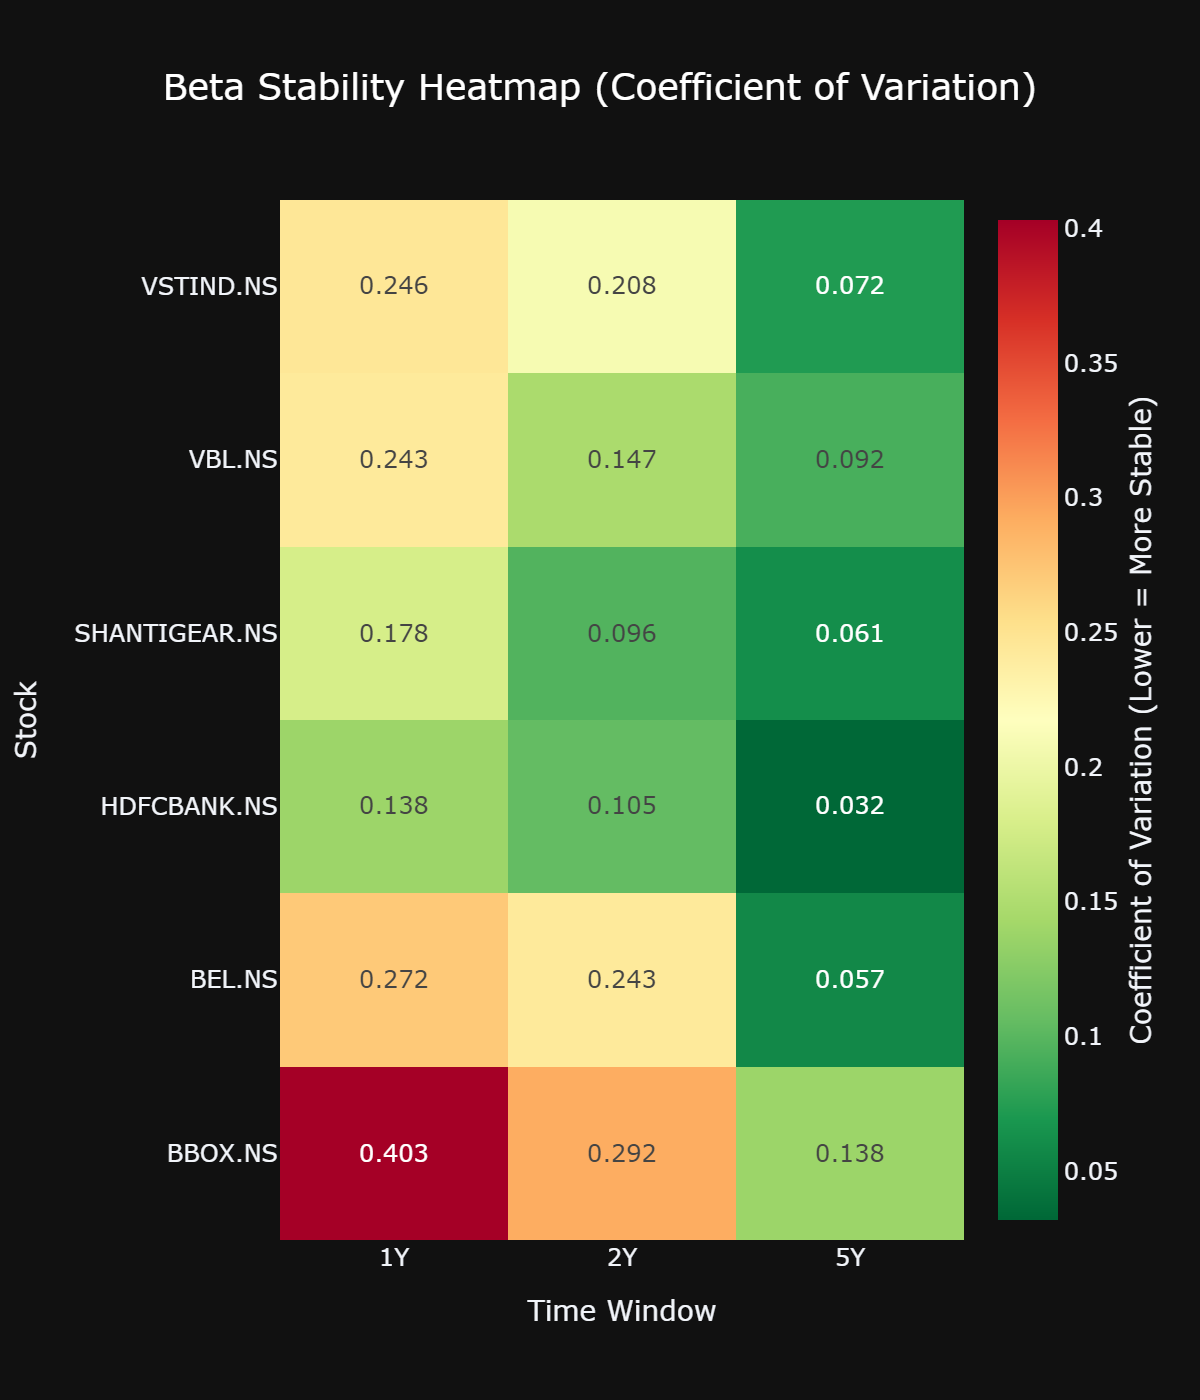

In [9]:
def create_stability_heatmap_plotly(stability_metrics, save_plot=True):
    heatmap_data = []
    stocks = []
    windows = ['1Y', '2Y', '5Y']
    for stock in stability_metrics:
        stocks.append(stock)
        row = []
        for window in windows:
            if window in stability_metrics[stock]:
                cv = stability_metrics[stock][window]['cv_beta']
                row.append(cv if cv != np.inf else np.nan)
            else:
                row.append(np.nan)
        heatmap_data.append(row)
    heatmap_df = pd.DataFrame(heatmap_data, columns=windows, index=stocks)
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data,
        x=windows,
        y=stocks,
        colorscale='RdYlGn_r',
        text=[[f'{val:.3f}' if not pd.isna(val) else 'N/A' for val in row] for row in heatmap_data],
        texttemplate="%{text}",
        textfont={"size": 12},
        hoverongaps=False,
        colorbar=dict(
            title=dict(
                text="Coefficient of Variation\n(Lower = More Stable)",
                side="right"
            )
        )
    ))
    fig.update_layout(
        title=dict(
            text='Beta Stability Heatmap\n(Coefficient of Variation)',
            font=dict(size=18, color='white'),
            x=0.5
        ),
        xaxis_title='Time Window',
        yaxis_title='Stock',
        template='plotly_dark',
        width=600,
        height=700
    )
    if save_plot:
        fig.write_image("Beta_stability_heatmap.png", width=2800, height=1800, scale=2)
        fig.write_image("Beta_stability_heatmap.svg", width=2800, height=1800)
        fig.write_html("Beta_stability_heatmap.html")
    fig.show()
    return heatmap_df, fig

stability_heatmap, heatmap_fig = create_stability_heatmap_plotly(stability_metrics)